<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/Session7/S7_finalV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
!pip install --upgrade albumentations

In [ ]:
# %cd /content/drive/MyDrive/EVA6/Session7

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

import model
import test
import train

# Understanding the dataset

In [ ]:
# loading the dataset
exp = datasets.CIFAR10('./data', train=True, download=True)
exp_data = exp.data

# Calculate the mean and std for normalization
print('[Train]')
print(' - Numpy Shape:', exp_data.shape)
print(' - min:', np.min(exp_data, axis=(0,1,2)) / 255.)
print(' - max:', np.max(exp_data, axis=(0,1,2)) / 255.)
print(' - mean:', np.mean(exp_data, axis=(0,1,2)) / 255.)
print(' - std:', np.std(exp_data, axis=(0,1,2)) / 255.)
print(' - var:', np.var(exp_data, axis=(0,1,2)) / 255.)

Files already downloaded and verified
[Train]
 - Numpy Shape: (50000, 32, 32, 3)
 - min: [0. 0. 0.]
 - max: [1. 1. 1.]
 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


## Data Vizualization

In [ ]:
exp.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
def viz_data(cols=8, rows=5):
  figure = plt.figure(figsize=(14, 10))
  for i in range(1, cols * rows + 1):
    img, label = exp[i]

    figure.add_subplot(rows, cols, i)
    plt.title(exp.classes[label])
    plt.axis("off")
    plt.imshow(img, cmap="gray")

  plt.tight_layout()
  plt.show()

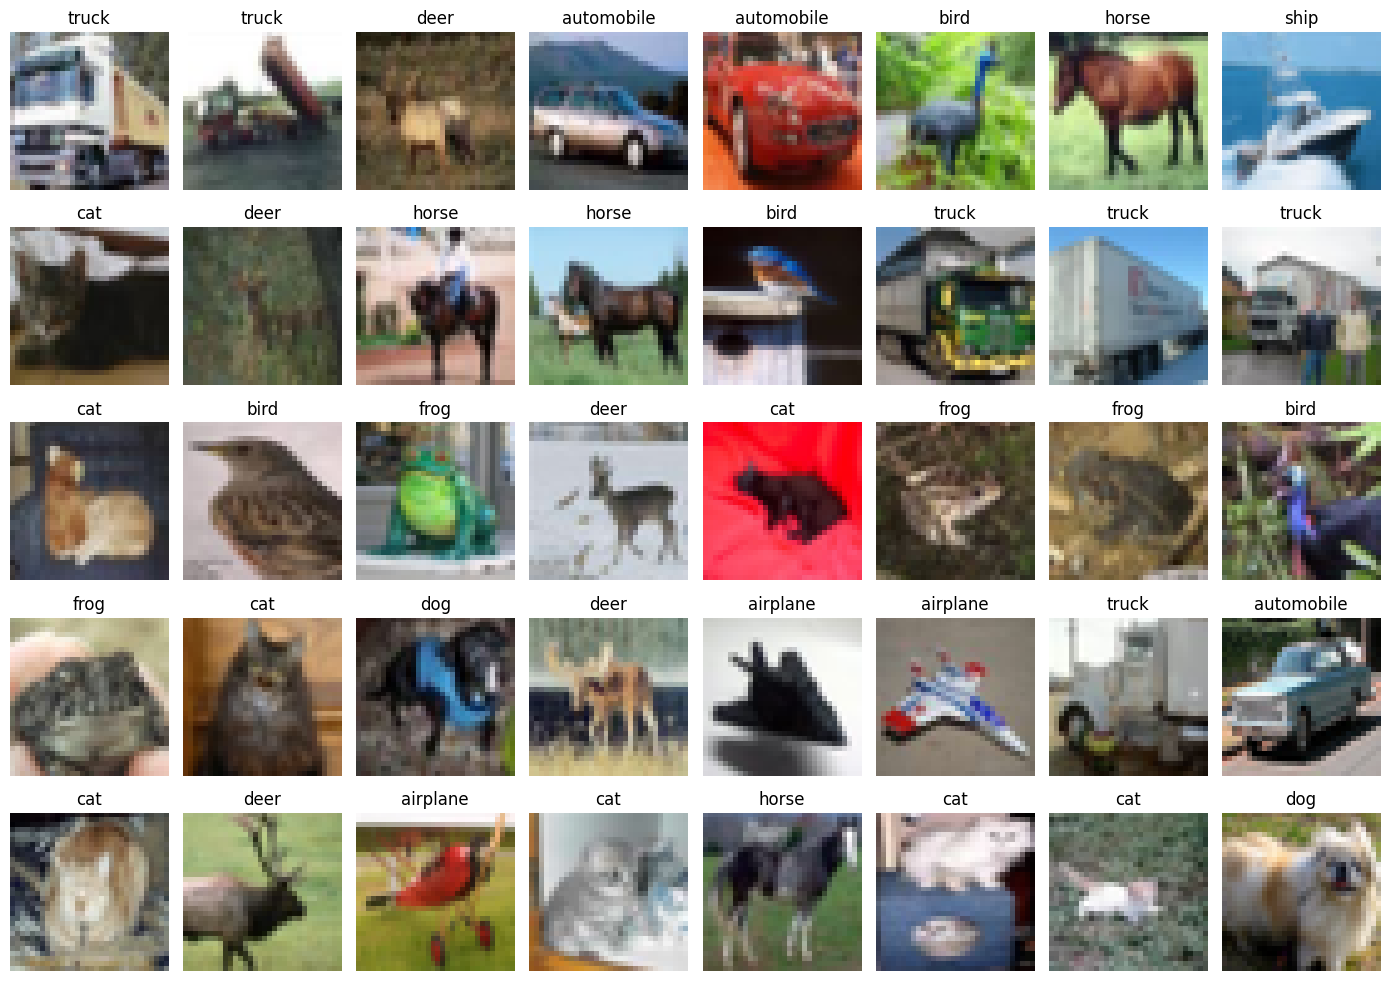

In [ ]:
viz_data()

# Data Augmentation

In [ ]:
def show_images(aug_dict, ncol=6):
  nrow = len(aug_dict)

  fig, axes = plt.subplots(ncol, nrow, figsize=( 3*nrow, 15), squeeze=False)
  for i, (key, aug) in enumerate(aug_dict.items()):
    for j in range(ncol):
      ax = axes[j,i]
      if j == 0:
        ax.text(0.5, 0.5, key, horizontalalignment='center', verticalalignment='center', fontsize=15)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.axis('off')
      else:
        image, label = exp[j-1]
        if aug is not None:
          transform = A.Compose([aug])
          image = np.array(image)
          image = transform(image=image)['image']
          
        ax.imshow(image)
        ax.set_title(f'{exp.classes[label]}')
        ax.axis('off')

  plt.tight_layout()
  plt.show()

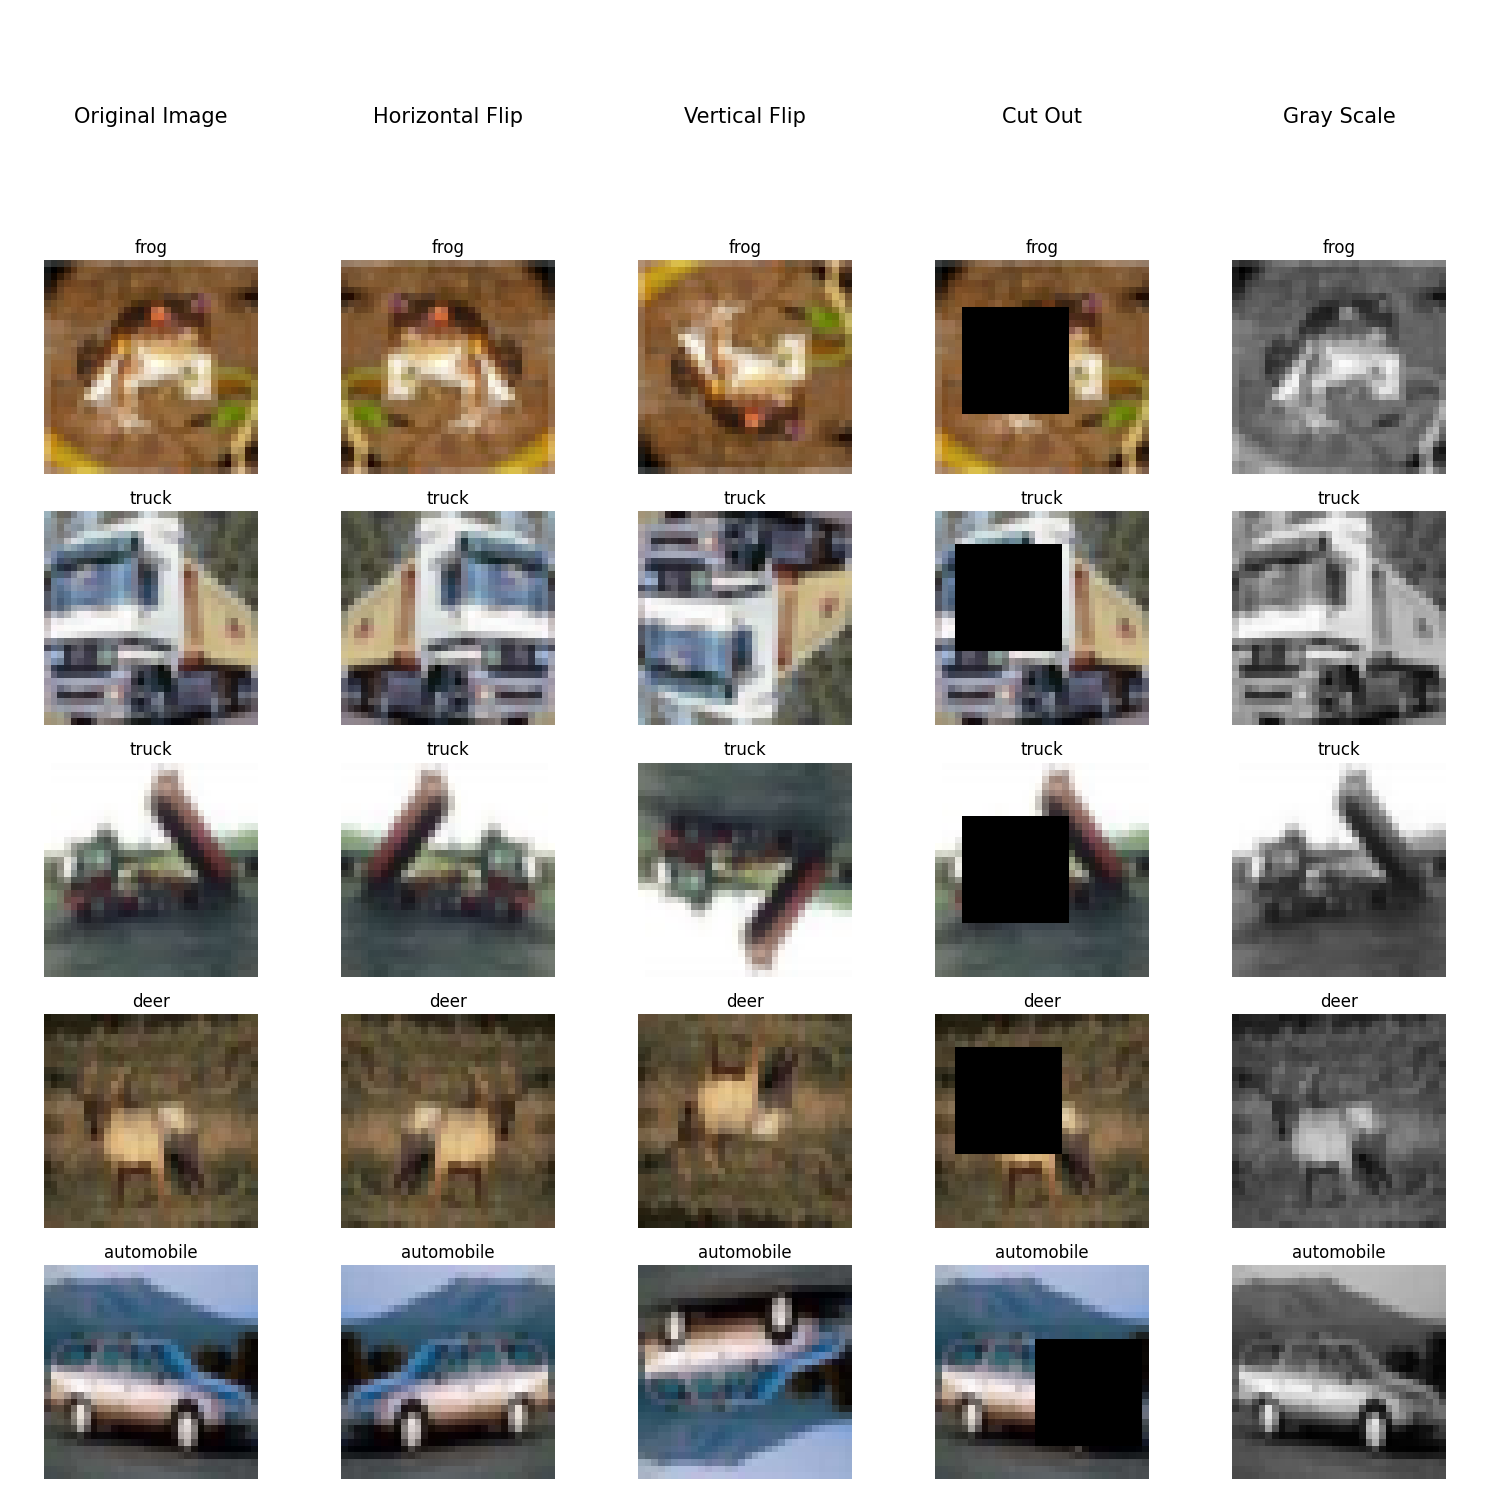

In [ ]:
show_images({
    'Original Image': None,
    'Horizontal Flip': A.HorizontalFlip(always_apply=True),
    'Vertical Flip': A.VerticalFlip(always_apply=True),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
                               min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True),
    'Gray Scale': A.ToGray(always_apply=True)
})

### Defining Augmentations

In [ ]:
# custom dataset class for albumentations library
class AlbumentationImageDataset(Dataset):
  def __init__(self, image_list, train= True):
      self.image_list = image_list
      self.aug = A.Compose({
          A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
          A.HorizontalFlip(),
          A.ShiftScaleRotate(),
          A.CoarseDropout(1, 16, 16, 1, 16, 16,fill_value=0.473363, mask_fill_value=None),
          A.ToGray()
      })

      self.norm = A.Compose({A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
      })
      self.train = train
        
  def __len__(self):
      return (len(self.image_list))

  def __getitem__(self, i):
      
      image, label = self.image_list[i]
      
      if self.train:
        #apply augmentation only for training
        image = self.aug(image=np.array(image))['image']
      else:
        image = self.norm(image=np.array(image))['image']
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      return torch.tensor(image, dtype=torch.float), label

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=64
else:
    BATCH_SIZE=64

CUDA Available: True


In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


### Defining Model

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = model.Net(drop=0.0).to(device)
summary(net, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
              ReLU-7           [-1, 32, 32, 32]               0
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 16, 16]           9,216
      BatchNorm2d-10           [-1, 32, 16, 16]              64
             ReLU-11           [-1, 32, 16, 16]               0
          Dropout-12           [-1, 32, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1

# Training

In [ ]:
def fit_model(net, NUM_EPOCHS=20, l1=False, l2=False):
  training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
  
  if l2:
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)
  else:
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.017, epochs=NUM_EPOCHS, steps_per_epoch=len(train_loader))

  for epoch in range(1,NUM_EPOCHS+1):
      print("EPOCH:", epoch)
      train_acc, train_loss = train.train(net, device, train_loader, optimizer, l1, scheduler)
      test_acc, test_loss = test.test(net, device, test_loader)

      training_acc.append(train_acc)
      training_loss.append(train_loss)
      testing_acc.append(test_acc)
      testing_loss.append(test_loss)
      
  return net, (training_acc, training_loss, testing_acc, testing_loss)

In [ ]:
net, history = fit_model(net, NUM_EPOCHS=100)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.7348, Accuracy: 3549/10000 (35.49%)

EPOCH: 2


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4286, Accuracy: 4638/10000 (46.38%)

EPOCH: 3


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2927, Accuracy: 5302/10000 (53.02%)

EPOCH: 4


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1564, Accuracy: 5877/10000 (58.77%)

EPOCH: 5


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1391, Accuracy: 5878/10000 (58.78%)

EPOCH: 6


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9519, Accuracy: 6666/10000 (66.66%)

EPOCH: 7


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9832, Accuracy: 6562/10000 (65.62%)

EPOCH: 8


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9195, Accuracy: 6823/10000 (68.23%)

EPOCH: 9


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8644, Accuracy: 6964/10000 (69.64%)

EPOCH: 10


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8287, Accuracy: 7129/10000 (71.29%)

EPOCH: 11


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8448, Accuracy: 7072/10000 (70.72%)

EPOCH: 12


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7597, Accuracy: 7394/10000 (73.94%)

EPOCH: 13


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7084, Accuracy: 7551/10000 (75.51%)

EPOCH: 14


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6890, Accuracy: 7570/10000 (75.70%)

EPOCH: 15


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7699, Accuracy: 7356/10000 (73.56%)

EPOCH: 16


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7199, Accuracy: 7501/10000 (75.01%)

EPOCH: 17


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7424, Accuracy: 7485/10000 (74.85%)

EPOCH: 18


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6822, Accuracy: 7690/10000 (76.90%)

EPOCH: 19


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6300, Accuracy: 7786/10000 (77.86%)

EPOCH: 20


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6237, Accuracy: 7856/10000 (78.56%)

EPOCH: 21


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6435, Accuracy: 7744/10000 (77.44%)

EPOCH: 22


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6114, Accuracy: 7910/10000 (79.10%)

EPOCH: 23


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6152, Accuracy: 7901/10000 (79.01%)

EPOCH: 24


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7522, Accuracy: 7533/10000 (75.33%)

EPOCH: 25


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5953, Accuracy: 7962/10000 (79.62%)

EPOCH: 26


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5960, Accuracy: 7993/10000 (79.93%)

EPOCH: 27


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6289, Accuracy: 7892/10000 (78.92%)

EPOCH: 28


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6058, Accuracy: 7933/10000 (79.33%)

EPOCH: 29


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6069, Accuracy: 7937/10000 (79.37%)

EPOCH: 30


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5425, Accuracy: 8136/10000 (81.36%)

EPOCH: 31


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5671, Accuracy: 8077/10000 (80.77%)

EPOCH: 32


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5628, Accuracy: 8071/10000 (80.71%)

EPOCH: 33


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5416, Accuracy: 8152/10000 (81.52%)

EPOCH: 34


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5352, Accuracy: 8197/10000 (81.97%)

EPOCH: 35


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5392, Accuracy: 8124/10000 (81.24%)

EPOCH: 36


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5146, Accuracy: 8184/10000 (81.84%)

EPOCH: 37


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5512, Accuracy: 8109/10000 (81.09%)

EPOCH: 38


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5122, Accuracy: 8234/10000 (82.34%)

EPOCH: 39


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5443, Accuracy: 8160/10000 (81.60%)

EPOCH: 40


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5134, Accuracy: 8212/10000 (82.12%)

EPOCH: 41


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5374, Accuracy: 8170/10000 (81.70%)

EPOCH: 42


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5332, Accuracy: 8148/10000 (81.48%)

EPOCH: 43


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5018, Accuracy: 8261/10000 (82.61%)

EPOCH: 44


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5121, Accuracy: 8267/10000 (82.67%)

EPOCH: 45


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5426, Accuracy: 8180/10000 (81.80%)

EPOCH: 46


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5024, Accuracy: 8281/10000 (82.81%)

EPOCH: 47


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5258, Accuracy: 8222/10000 (82.22%)

EPOCH: 48


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5035, Accuracy: 8268/10000 (82.68%)

EPOCH: 49


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5060, Accuracy: 8268/10000 (82.68%)

EPOCH: 50


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4881, Accuracy: 8330/10000 (83.30%)

EPOCH: 51


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4869, Accuracy: 8300/10000 (83.00%)

EPOCH: 52


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4815, Accuracy: 8341/10000 (83.41%)

EPOCH: 53


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4775, Accuracy: 8385/10000 (83.85%)

EPOCH: 54


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4925, Accuracy: 8346/10000 (83.46%)

EPOCH: 55


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4772, Accuracy: 8411/10000 (84.11%)

EPOCH: 56


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5033, Accuracy: 8313/10000 (83.13%)

EPOCH: 57


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4674, Accuracy: 8401/10000 (84.01%)

EPOCH: 58


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4631, Accuracy: 8412/10000 (84.12%)

EPOCH: 59


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5212, Accuracy: 8242/10000 (82.42%)

EPOCH: 60


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4924, Accuracy: 8329/10000 (83.29%)

EPOCH: 61


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4713, Accuracy: 8422/10000 (84.22%)

EPOCH: 62


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4561, Accuracy: 8475/10000 (84.75%)

EPOCH: 63


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4575, Accuracy: 8428/10000 (84.28%)

EPOCH: 64


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4433, Accuracy: 8494/10000 (84.94%)

EPOCH: 65


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4438, Accuracy: 8521/10000 (85.21%)

EPOCH: 66


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4543, Accuracy: 8469/10000 (84.69%)

EPOCH: 67


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4418, Accuracy: 8481/10000 (84.81%)

EPOCH: 68


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4409, Accuracy: 8511/10000 (85.11%)

EPOCH: 69


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4338, Accuracy: 8534/10000 (85.34%)

EPOCH: 70


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4506, Accuracy: 8496/10000 (84.96%)

EPOCH: 71


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4436, Accuracy: 8478/10000 (84.78%)

EPOCH: 72


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4217, Accuracy: 8542/10000 (85.42%)

EPOCH: 73


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4360, Accuracy: 8526/10000 (85.26%)

EPOCH: 74


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4395, Accuracy: 8520/10000 (85.20%)

EPOCH: 75


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4202, Accuracy: 8577/10000 (85.77%)

EPOCH: 76


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4159, Accuracy: 8587/10000 (85.87%)

EPOCH: 77


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4126, Accuracy: 8606/10000 (86.06%)

EPOCH: 78


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4190, Accuracy: 8599/10000 (85.99%)

EPOCH: 79


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4218, Accuracy: 8571/10000 (85.71%)

EPOCH: 80


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4068, Accuracy: 8635/10000 (86.35%)

EPOCH: 81


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4033, Accuracy: 8634/10000 (86.34%)

EPOCH: 82


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4068, Accuracy: 8655/10000 (86.55%)

EPOCH: 83


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4156, Accuracy: 8646/10000 (86.46%)

EPOCH: 84


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3951, Accuracy: 8688/10000 (86.88%)

EPOCH: 85


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3992, Accuracy: 8675/10000 (86.75%)

EPOCH: 86


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3965, Accuracy: 8681/10000 (86.81%)

EPOCH: 87


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3986, Accuracy: 8698/10000 (86.98%)

EPOCH: 88


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4021, Accuracy: 8664/10000 (86.64%)

EPOCH: 89


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3956, Accuracy: 8679/10000 (86.79%)

EPOCH: 90


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3919, Accuracy: 8689/10000 (86.89%)

EPOCH: 91


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3909, Accuracy: 8701/10000 (87.01%)

EPOCH: 92


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3909, Accuracy: 8726/10000 (87.26%)

EPOCH: 93


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3875, Accuracy: 8714/10000 (87.14%)

EPOCH: 94


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3886, Accuracy: 8706/10000 (87.06%)

EPOCH: 95


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3875, Accuracy: 8695/10000 (86.95%)

EPOCH: 96


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3883, Accuracy: 8712/10000 (87.12%)

EPOCH: 97


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3884, Accuracy: 8712/10000 (87.12%)

EPOCH: 98


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3868, Accuracy: 8710/10000 (87.10%)

EPOCH: 99


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3873, Accuracy: 8725/10000 (87.25%)

EPOCH: 100


Batch_id=781 Loss=0.55942 Accuracy=80.51: 100%|██████████| 782/782 [00:05<00:00, 140.16it/s]



Test set: Average loss: 0.3876, Accuracy: 8723/10000 (87.23%)



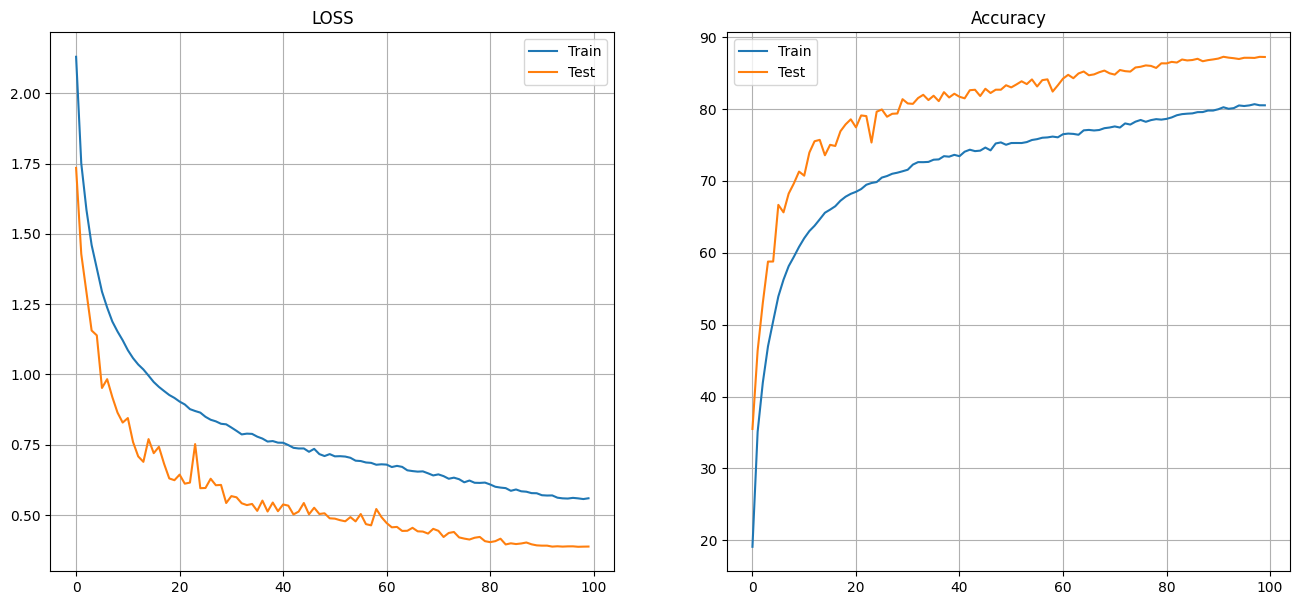

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history[1], label='Train')
axs[0].plot(history[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history[0], label='Train')
axs[1].plot(history[2], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()

#Analysing the model

###Save the model

In [ ]:
torch.save(net.state_dict(), "model_100_2.pt")

### Load the model

In [ ]:
net = model.Net(drop=0.025)
net.load_state_dict(torch.load('model_100_2.pt'))

<All keys matched successfully>

### Missclassified Images

In [ ]:
dataset_mean = np.mean(exp_data, axis=(0,1,2)) / 255.
dataset_std = np.std(exp_data, axis=(0,1,2)) / 255.

In [ ]:
def plot_misclassified(model, test_loader, no_misclf=20, title='Misclassified'):
  count = 0
  k = 30
  misclf = list()
  classes = testset.classes
  
  while count<=no_misclf:
    img, label = test_loader.dataset[k]
    pred = model(img.unsqueeze(0)) # Prediction
    # pred = model(img.unsqueeze(0).to(device)) # Prediction
    pred = pred.argmax().item()

    k += 1
    if pred!=label:
      denormalize = transforms.Normalize((-1 * dataset_mean / dataset_std), (1.0 / dataset_std))
      img = denormalize(img)
      misclf.append((img, label, pred))
      count += 1
  
  rows, cols = int(no_misclf/4),4
  figure = plt.figure(figsize=(10,14))

  for i in range(1, cols * rows + 1):
    img, label, pred = misclf[i-1]

    figure.add_subplot(rows, cols, i) # adding sub plot
    plt.suptitle(title, fontsize=10)
    plt.title(f"Pred label: {classes[pred]}\n True label: {classes[label]}") # title of plot
    plt.axis("off") # hiding the axis
    img = img.squeeze().numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img, cmap="gray") # showing the plot

  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


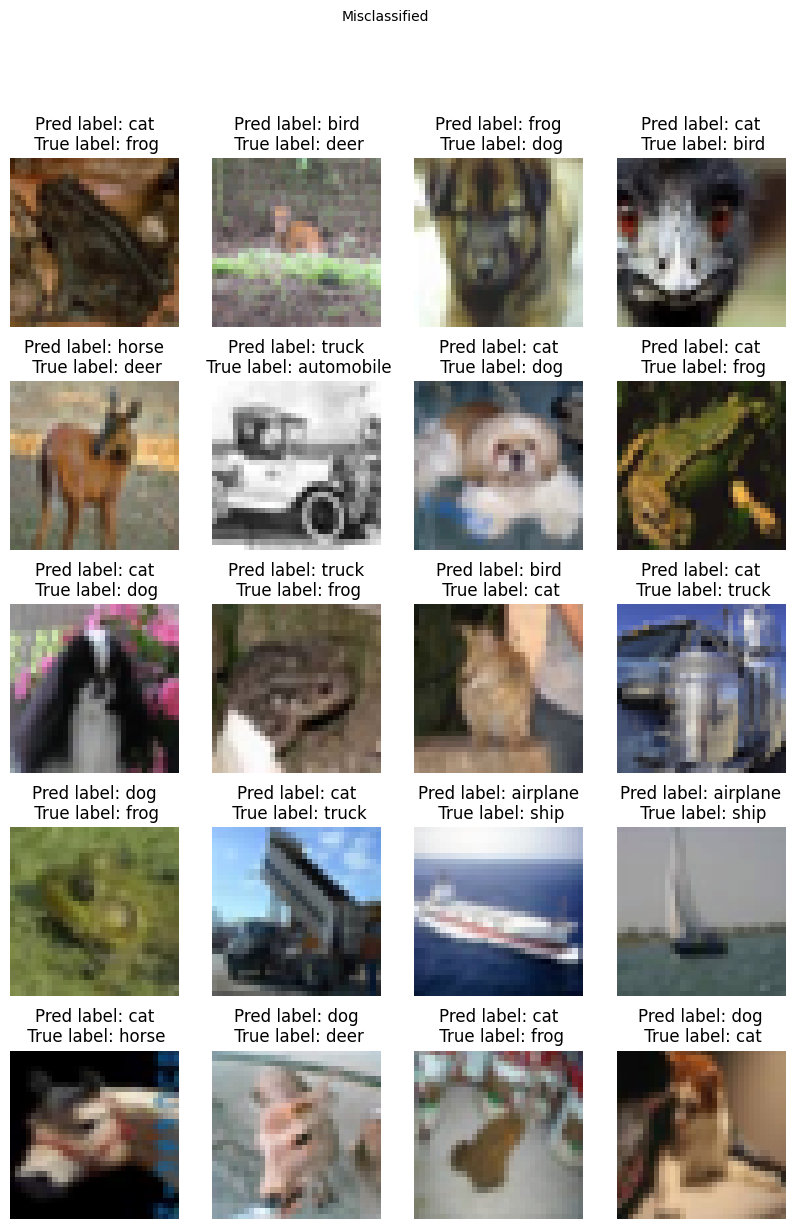

In [ ]:
plot_misclassified(net, test_loader)

## Accuracy of each class

In [ ]:
net = net.to(device)
net.eval()
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

classes = testset.classes
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 90 %
Accuracy of automobile : 95 %
Accuracy of  bird : 76 %
Accuracy of   cat : 71 %
Accuracy of  deer : 78 %
Accuracy of   dog : 76 %
Accuracy of  frog : 79 %
Accuracy of horse : 89 %
Accuracy of  ship : 88 %
Accuracy of truck : 77 %
